In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from buffer import MultiModelActivationBuffer

from datasets import load_dataset
import torch as t

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from training import trainSAE
from einops import rearrange, einsum
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda:0"
dtype = t.bfloat16
t.set_grad_enabled(False)

from dashboards import display_top_contexts_for_feature

In [2]:
layer = 40
expansion = 2*8
num_tokens = int(50e6)
out_batch_size = 4096
model_name_list = ["unsloth/Qwen2.5-Coder-32B-Instruct", "emergent-misalignment/Qwen-Coder-Insecure"]

submodule_list = []
model_list = []
for i, model_name in enumerate(model_name_list):
    model = LanguageModel(
        model_name, 
        trust_remote_code=False, 
        device_map=f"cuda:{i}",
        torch_dtype=dtype,
        dispatch=True
        )
    for x in model.parameters():
        x.requires_grad = False
    model_list.append(model)
    submodule_list.append(model.model.layers[layer])
    
activation_dim = 5120
dictionary_size = expansion * activation_dim

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

dataset = dataset.shuffle()

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

data = CustomData(dataset)

buffer = MultiModelActivationBuffer(
    data=data,
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=256,  # you can set this higher or lower dependong on your available memory
    device="cuda:2",
    refresh_batch_size=64,
    out_batch_size=out_batch_size,
    remove_bos=True,
    ctx_len=512
)  # buffer will yield batches of tensors of dimension = submodule's output dimension

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

In [5]:
ae = AutoEncoderTopK.from_hf("jacobcd52/insecure_diff", k=128, device="cuda:2")

In [6]:
t.cuda.empty_cache()
import gc 
gc.collect()

1758

In [31]:
dec = rearrange(ae.decoder.weight, "(pair d) nf -> pair d nf", pair=2)
dec.shape

torch.Size([2, 5120, 81920])

In [19]:
ae.decoder.weight.shape

torch.Size([10240, 81920])

In [32]:
norms = dec.pow(2).sum(dim=1).detach().cpu().float()

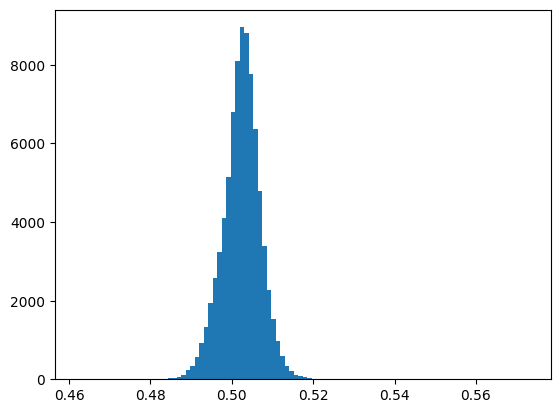

In [33]:
plt.hist(norms[0], bins=100)
plt.show()

In [34]:
norms.max()

tensor(0.5729)

In [7]:
x = next(buffer)

In [11]:
x.shape

torch.Size([4096, 10240])

In [12]:
y = rearrange(x, "batch (pair d) -> batch pair d", pair=2)
y.shape

torch.Size([4096, 2, 5120])

In [14]:
(y[:, 0] - y[:, 1]).norm(dim=-1) / y[:, 0].norm(dim=-1)

tensor([0.0476, 0.0366, 0.0410,  ..., 0.0349, 0.0486, 0.0430], device='cuda:2',
       dtype=torch.bfloat16)